<a href="https://colab.research.google.com/github/MeedumiRashmika/Researchbasic/blob/main/Test_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow pandas numpy

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
from google.colab import files

print("Upload Model 1 dataset (shelf life)...")
uploaded1 = files.upload()

print("Upload Model 2 dataset (packaging)...")
uploaded2 = files.upload()


Upload Model 1 dataset (shelf life)...


Saving model1_shelf_life_1349_rows.xlsx to model1_shelf_life_1349_rows.xlsx
Upload Model 2 dataset (packaging)...


Saving model2_mango_packaging_1249rows.xlsx to model2_mango_packaging_1249rows.xlsx


In [7]:
# Change filenames if needed
df1 = pd.read_excel("model1_shelf_life_1349_rows.xlsx")
df2 = pd.read_excel("model2_mango_packaging_1249rows.xlsx")

print("Model 1 dataset shape:", df1.shape)
print(df1.head())

print("Model 2 dataset shape:", df2.shape)
print(df2.head())


Model 1 dataset shape: (1349, 6)
  ripeness_level  avg_weight_g origin_location_district  avg_temperature_C  \
0         Unripe           305             Anuradhapura               31.0   
1         Unripe           298                   Jaffna               32.0   
2         Unripe           310               Kurunegala               30.0   
3         Unripe           290                  Gampaha               29.0   
4         Unripe           315                    Kandy               24.0   

   avg_humidity_pct  predicted_shelf_life_days  
0                68                       15.0  
1                70                       14.0  
2                72                       16.0  
3                75                       17.0  
4                80                       18.0  
Model 2 dataset shape: (1249, 21)
  ripeness_level  avg_weight_g  number_of_mangoes origin_country  \
0           Ripe         311.0               1104      Sri Lanka   
1         Unripe         283.0    

In [8]:
# Adjust columns to match your actual dataset
model1_feature_cols = ["ripeness_level", "avg_weight_g", "avg_temperature_C", "avg_humidity_pct"]
model1_label_col = "predicted_shelf_life_days"

X1 = df1[model1_feature_cols].copy()
y1 = df1[model1_label_col].astype("float32")


In [9]:
# Separate numeric and categorical columns
m1_cat_cols = ["ripeness_level"]
m1_num_cols = ["avg_weight_g", "avg_temperature_C", "avg_humidity_pct"]

# Keras input layers
inputs_m1 = {}

for col in m1_cat_cols:
    inputs_m1[col] = keras.Input(shape=(1,), name=col, dtype=tf.string)
for col in m1_num_cols:
    inputs_m1[col] = keras.Input(shape=(1,), name=col, dtype=tf.float32)

# Build preprocessing for categorical
encoded_cat_features = []
for col in m1_cat_cols:
    lookup = layers.StringLookup(output_mode="int", name=f"{col}_lookup")
    lookup.adapt(X1[col].values)
    # one-hot encode
    encoder = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size(), output_mode="one_hot", name=f"{col}_onehot")
    x = lookup(inputs_m1[col])
    x = encoder(x)
    encoded_cat_features.append(x)

# Build preprocessing for numeric
normalized_num_features = []
for col in m1_num_cols:
    norm = layers.Normalization(name=f"{col}_norm")
    norm.adapt(X1[col].values.reshape(-1, 1))
    x = norm(inputs_m1[col])
    normalized_num_features.append(x)

# Concatenate all features
all_features_m1 = layers.concatenate(encoded_cat_features + normalized_num_features)


In [10]:
# Define the model
x = layers.Dense(32, activation="relu")(all_features_m1)
x = layers.Dense(32, activation="relu")(x)
output_m1 = layers.Dense(1, name="shelf_life_days")(x)

model1_tf = keras.Model(inputs=inputs_m1, outputs=output_m1)

model1_tf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

model1_tf.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ripeness_level      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ripeness_level_loo… │ (None, 1)         │          0 │ ripeness_level[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_weight_g        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_temperature_C   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_humidity_pct    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ripeness_level_one… │ (None, 4)         │          0 │ ripeness_level_l… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_weight_g_norm   │ (None, 1)         │          3 │ avg_weight_g[0][… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_temperature_C_… │ (None, 1)         │          3 │ avg_temperature_… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_humidity_pct_n… │ (None, 1)         │          3 │ avg_humidity_pct… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7)         │          0 │ ripeness_level_o… │
│ (Concatenate)       │                   │            │ avg_weight_g_nor… │
│                     │                   │            │ avg_temperature_… │
│                     │                   │            │ avg_humidity_pct… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shelf_life_days     │ (None, 1)         │         33 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,354 (5.30 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 9 (48.00 B)

In [11]:
# Convert pandas to dict of numpy arrays for training
train_dict_m1 = {col: X1[col].values for col in model1_feature_cols}

history_m1 = model1_tf.fit(
    train_dict_m1,
    y1.values,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 118.6310 - mae: 9.8118 - val_loss: 104.8494 - val_mae: 9.1029
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 86.6411 - mae: 8.1663 - val_loss: 56.3933 - val_mae: 6.3137
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39.9959 - mae: 5.1138 - val_loss: 14.1140 - val_mae: 2.9199
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8254 - mae: 2.5927 - val_loss: 7.0102 - val_mae: 2.0787
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0529 - mae: 2.1181 - val_loss: 5.4056 - val_mae: 1.8212
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4713 - mae: 1.8672 - val_loss: 4.4369 - val_mae: 1.6513
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5934 - mae: 1.6946 - val_loss: 3.5616 - val_mae: 1.4811
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6625 - mae: 1.5009 - val_loss: 3.0096 - val_mae: 1.3676
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.98

Model **2**

In [12]:
model2_feature_cols = [
    "ripeness_level",
    "avg_weight_g",
    "number_of_mangoes",
    "origin_country",
    "origin_port_airport",
    "destination_country",
    "destination_port_airport",
    "transport_mode",
    "transport_duration_days",
    "predicted_shelf_life_days",
    "packaging_material",
    "padding_type",
    "box_length_cm",
    "box_width_cm",
    "box_height_cm",
    "rows_per_layer",
    "items_per_row",
    "layers",
    "mangoes_per_box"
]

model2_label_col = "observed_damage_pct"

X2 = df2[model2_feature_cols].copy()
y2 = df2[model2_label_col].astype("float32")


In [13]:
# Identify categorical and numeric columns for model 2
m2_cat_cols = [
    "ripeness_level",
    "origin_country",
    "origin_port_airport",
    "destination_country",
    "destination_port_airport",
    "transport_mode",
    "packaging_material",
    "padding_type"
]

m2_num_cols = [c for c in model2_feature_cols if c not in m2_cat_cols]

# Keras Inputs
inputs_m2 = {}

for col in m2_cat_cols:
    inputs_m2[col] = keras.Input(shape=(1,), name=col, dtype=tf.string)
for col in m2_num_cols:
    inputs_m2[col] = keras.Input(shape=(1,), name=col, dtype=tf.float32)

# Categorical preprocessing
encoded_cat_features_2 = []
for col in m2_cat_cols:
    lookup = layers.StringLookup(output_mode="int", name=f"{col}_lookup")
    lookup.adapt(X2[col].values)
    encoder = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size(), output_mode="one_hot", name=f"{col}_onehot")
    x = lookup(inputs_m2[col])
    x = encoder(x)
    encoded_cat_features_2.append(x)

# Numeric preprocessing
normalized_num_features_2 = []
for col in m2_num_cols:
    norm = layers.Normalization(name=f"{col}_norm")
    norm.adapt(X2[col].values.reshape(-1, 1))
    x = norm(inputs_m2[col])
    normalized_num_features_2.append(x)

# Concatenate all features
all_features_m2 = layers.concatenate(encoded_cat_features_2 + normalized_num_features_2)


In [14]:
x2 = layers.Dense(64, activation="relu")(all_features_m2)
x2 = layers.Dense(64, activation="relu")(x2)
output_m2 = layers.Dense(1, name="damage_pct")(x2)

model2_tf = keras.Model(inputs=inputs_m2, outputs=output_m2)

model2_tf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

model2_tf.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ripeness_level      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ origin_country      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ origin_port_airport │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_country │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_port_a… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transport_mode      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ packaging_material  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_type        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ripeness_level_loo… │ (None, 1)         │          0 │ ripeness_level[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ origin_country_loo… │ (None, 1)         │          0 │ origin_country[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ origin_port_airpor… │ (None, 1)         │          0 │ origin_port_airp… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_countr… │ (None, 1)         │          0 │ destination_coun… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_port_a… │ (None, 1)         │          0 │ destination_port… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transport_mode_loo… │ (None, 1)         │          0 │ transport_mode[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ packaging_material… │ (None, 1)         │          0 │ packaging_materi… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_type_lookup │ (None, 1)         │          0 │ padding_type[0][… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_weight_g        │ (None, 1)         │          0 │ -               

 Total params: 8,546 (33.43 KB)

 Trainable params: 8,513 (33.25 KB)

 Non-trainable params: 33 (176.00 B)

In [15]:
train_dict_m2 = {col: X2[col].values for col in model2_feature_cols}

history_m2 = model2_tf.fit(
    train_dict_m2,
    y2.values,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1
)


Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 108.5175 - mae: 9.3150 - val_loss: 48.9007 - val_mae: 5.4934
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33.6941 - mae: 4.4386 - val_loss: 15.7343 - val_mae: 3.1668
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.1033 - mae: 2.8230 - val_loss: 8.0044 - val_mae: 2.1832
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5262 - mae: 2.0164 - val_loss: 6.4414 - val_mae: 1.9620
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3793 - mae: 1.8224 - val_loss: 5.8297 - val_mae: 1.8848
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7199 - mae: 1.7181 - val_loss: 5.3532 - val_mae: 1.7950
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2242 - mae: 1.6222 - val_loss: 4.9313 - val_mae: 1.7343
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8024 - mae: 1.5217 - val_loss: 4.6248 - val_mae: 1.6916
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7950 

**FULL PIPELINE**

In [16]:
transport_table = {
    ("UAE", "Air"): 1,
    ("UAE", "Sea"): 16,
    ("Qatar", "Air"): 1,
    ("Qatar", "Sea"): 12,
    ("Saudi Arabia", "Air"): 1,
    ("Saudi Arabia", "Sea"): 9,
    ("Oman", "Air"): 1,
    ("Oman", "Sea"): 8,
    ("Kuwait", "Air"): 1,
    ("Kuwait", "Sea"): 14,
    ("Germany", "Air"): 2,
    ("Germany", "Sea"): 22,
    ("Netherlands", "Air"): 2,
    ("Netherlands", "Sea"): 24,
    ("UK", "Air"): 2,
    ("UK", "Sea"): 21,
    ("Japan", "Air"): 2,
    ("Japan", "Sea"): 18,
    ("United States", "Air"): 2,
    ("United States", "Sea"): 30,
    ("Australia", "Air"): 2,
    ("Australia", "Sea"): 16,
}

def get_transport_duration(destination_country, mode):
    return transport_table.get((destination_country, mode), 10)


In [17]:
legal_rules = {
    "Germany":      {"allowed_materials": ["Fiberboard", "BioFiber", "Cardboard"], "banned_materials": []},
    "UAE":          {"allowed_materials": ["Fiberboard", "Cardboard"],             "banned_materials": ["BioFiber"]},
    "Netherlands":  {"allowed_materials": ["Fiberboard", "BioFiber"],             "banned_materials": ["Cardboard"]},
    "United States":{"allowed_materials": ["Fiberboard", "Cardboard", "BioFiber"],"banned_materials": []},
    # add other countries here...
}

eco_score = {
    "BioFiber": 1,
    "Fiberboard": 2,
    "Cardboard": 3
}


In [18]:
candidate_packaging_options = [
    {"packaging_material": "Fiberboard", "padding_type": "Foam",    "box_length_cm": 40, "box_width_cm": 30, "box_height_cm": 18, "rows_per_layer": 4, "items_per_row": 5, "layers": 1},
    {"packaging_material": "Fiberboard", "padding_type": "Paper",   "box_length_cm": 40, "box_width_cm": 30, "box_height_cm": 16, "rows_per_layer": 3, "items_per_row": 5, "layers": 1},
    {"packaging_material": "BioFiber",   "padding_type": "Foam",    "box_length_cm": 38, "box_width_cm": 28, "box_height_cm": 16, "rows_per_layer": 3, "items_per_row": 4, "layers": 1},
    {"packaging_material": "Cardboard",  "padding_type": "Netting", "box_length_cm": 42, "box_width_cm": 32, "box_height_cm": 18, "rows_per_layer": 4, "items_per_row": 5, "layers": 2},
]


In [21]:
def recommend_packaging_tf(
    ripeness_level,
    avg_weight_g,
    number_of_mangoes,
    destination_country,
    transport_mode,
    origin_country="Sri Lanka"
):
    # 1) Choose origin port/airport
    origin_port_airport = "Colombo Port" if transport_mode == "Sea" else "CMB Airport"

    # 2) Predict shelf life (Model 1 TF)
    shelf_input = {
        "ripeness_level": tf.constant([ripeness_level], dtype=tf.string),
        "avg_weight_g": np.array([avg_weight_g], dtype="float32"),
        "avg_temperature_C": np.array([28.0], dtype="float32"),
        "avg_humidity_pct": np.array([75.0], dtype="float32"),
    }

    predicted_shelf_life = float(model1_tf.predict(shelf_input, verbose=0)[0][0])

    # 3) Get transport duration
    transport_duration_days = get_transport_duration(destination_country, transport_mode)

    # 4) Build candidates for Model 2
    candidate_rows = []

    for opt in candidate_packaging_options:
        rows_per_layer = opt["rows_per_layer"]
        items_per_row = opt["items_per_row"]
        layers = opt["layers"]
        mangoes_per_box = rows_per_layer * items_per_row * layers

        candidate_rows.append({
            "ripeness_level": ripeness_level,
            "avg_weight_g": float(avg_weight_g),
            "number_of_mangoes": int(number_of_mangoes),
            "origin_country": origin_country,
            "origin_port_airport": origin_port_airport,
            "destination_country": destination_country,
            "destination_port_airport": "DEST_PORT_OR_AIRPORT",  # optional detailed mapping
            "transport_mode": transport_mode,
            "transport_duration_days": float(transport_duration_days),
            "predicted_shelf_life_days": float(predicted_shelf_life),
            "packaging_material": opt["packaging_material"],
            "padding_type": opt["padding_type"],
            "box_length_cm": float(opt["box_length_cm"]),
            "box_width_cm": float(opt["box_width_cm"]),
            "box_height_cm": float(opt["box_height_cm"]),
            "rows_per_layer": float(rows_per_layer),
            "items_per_row": float(items_per_row),
            "layers": float(layers),
            "mangoes_per_box": float(mangoes_per_box),
        })

    df_candidates = pd.DataFrame(candidate_rows)

    # 5) Prepare input dict for Model 2
    input_dict_m2 = {col: df_candidates[col].values for col in model2_feature_cols}

    damage_preds = model2_tf.predict(input_dict_m2, verbose=0).flatten()
    df_candidates["predicted_damage_pct"] = damage_preds

    # 6) Apply legal & eco filters
    rules = legal_rules.get(destination_country, {
        "allowed_materials": ["Fiberboard", "Cardboard", "BioFiber"],
        "banned_materials": []
    })

    def is_allowed(row):
        mat = row["packaging_material"]
        if mat in rules["banned_materials"]:
            return False
        if mat not in rules["allowed_materials"]:
            return False
        return True

    df_candidates["is_allowed"] = df_candidates.apply(is_allowed, axis=1)
    df_allowed = df_candidates[df_candidates["is_allowed"] == True].copy()

    if df_allowed.empty:
        # no allowed option → fallback to best damage
        df_sorted = df_candidates.sort_values("predicted_damage_pct")
        best = df_sorted.iloc[0]
        return best, None, df_candidates

    # sort by eco_score first, then by damage
    df_allowed["eco_rank"] = df_allowed["packaging_material"].map(eco_score)
    df_allowed = df_allowed.sort_values(["eco_rank", "predicted_damage_pct"])

    best_option = df_allowed.iloc[0]
    second_option = df_allowed.iloc[1] if len(df_allowed) > 1 else None

    return best_option, second_option, df_allowed

**Test the whole pipeline**

In [22]:
best, second, all_allowed = recommend_packaging_tf(
    ripeness_level="Semi-ripe",
    avg_weight_g=300,
    number_of_mangoes=1200,
    destination_country="Germany",
    transport_mode="Sea"
)

print("Best option:")
print(best[["packaging_material", "padding_type", "box_length_cm", "box_width_cm",
           "box_height_cm", "rows_per_layer", "items_per_row", "layers",
           "mangoes_per_box", "predicted_damage_pct"]])

if second is not None:
    print("\nSecond-best legal & eco-friendly option:")
    print(second[["packaging_material", "padding_type", "box_length_cm", "box_width_cm",
                 "box_height_cm", "rows_per_layer", "items_per_row", "layers",
                 "mangoes_per_box", "predicted_damage_pct"]])

Best option:
packaging_material       BioFiber
padding_type                 Foam
box_length_cm                38.0
box_width_cm                 28.0
box_height_cm                16.0
rows_per_layer                3.0
items_per_row                 4.0
layers                        1.0
mangoes_per_box              12.0
predicted_damage_pct    11.320325
Name: 2, dtype: object

Second-best legal & eco-friendly option:
packaging_material      Fiberboard
padding_type                  Foam
box_length_cm                 40.0
box_width_cm                  30.0
box_height_cm                 18.0
rows_per_layer                 4.0
items_per_row                  5.0
layers                         1.0
mangoes_per_box               20.0
predicted_damage_pct      11.62535
Name: 0, dtype: object


In [25]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Prepare input dictionary for evaluation, ensuring correct tensor shapes and dtypes
eval_dict_m1 = {}
for col in m1_cat_cols:
    eval_dict_m1[col] = tf.constant(X1_test[col].values, dtype=tf.string)
for col in m1_num_cols:
    eval_dict_m1[col] = tf.constant(X1_test[col].values.reshape(-1, 1), dtype=tf.float32)

m1_eval = model1_tf.evaluate(
    eval_dict_m1,
    y1_test,
    verbose=0
)

print("Model 1 Evaluation:")
print(f"Loss (MSE): {m1_eval[0]:.4f}")
print(f"MAE: {m1_eval[1]:.4f}")

Model 1 Evaluation:
Loss (MSE): 0.5374
MAE: 0.5823


In [26]:
from sklearn.metrics import r2_score

y1_pred = model1_tf.predict(
    {col: X1_test[col].values for col in model1_feature_cols},
    verbose=0
).flatten()

r2_m1 = r2_score(y1_test, y1_pred)
print("Model 1 R² Score:", r2_m1)


Model 1 R² Score: 0.9793094396591187


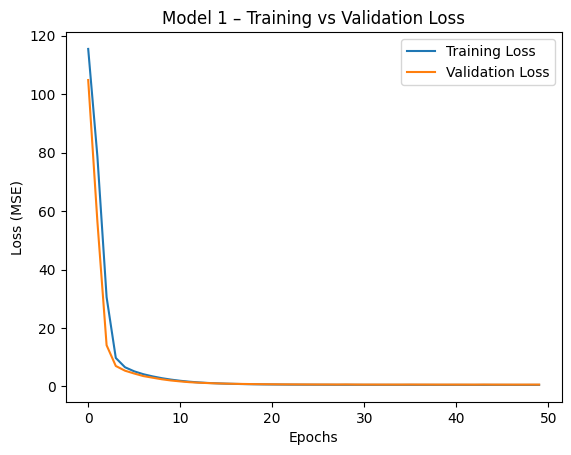

In [27]:
import matplotlib.pyplot as plt

plt.plot(history_m1.history["loss"], label="Training Loss")
plt.plot(history_m1.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model 1 – Training vs Validation Loss")
plt.legend()
plt.show()


In [29]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets for Model 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Prepare input dictionary for evaluation, ensuring correct tensor shapes and dtypes
eval_dict_m2 = {}
for col in m2_cat_cols:
    eval_dict_m2[col] = tf.constant(X2_test[col].values, dtype=tf.string)
for col in m2_num_cols:
    eval_dict_m2[col] = tf.constant(X2_test[col].values.reshape(-1, 1), dtype=tf.float32)

m2_eval = model2_tf.evaluate(
    eval_dict_m2,
    y2_test,
    verbose=0
)

print("Model 2 Evaluation:")
print(f"Loss (MSE): {m2_eval[0]:.4f}")
print(f"MAE: {m2_eval[1]:.4f}")

Model 2 Evaluation:
Loss (MSE): 1.7401
MAE: 1.0725


In [30]:
y2_pred = model2_tf.predict(
    {col: X2_test[col].values for col in model2_feature_cols},
    verbose=0
).flatten()

from sklearn.metrics import r2_score

r2_m2 = r2_score(y2_test, y2_pred)
print("Model 2 R² Score:", r2_m2)


Model 2 R² Score: 0.9194477796554565


In [31]:
def damage_to_class(x):
    if x <= 5:
        return "LOW"
    elif x <= 10:
        return "MEDIUM"
    else:
        return "HIGH"

y2_test_class = [damage_to_class(v) for v in y2_test]
y2_pred_class = [damage_to_class(v) for v in y2_pred]


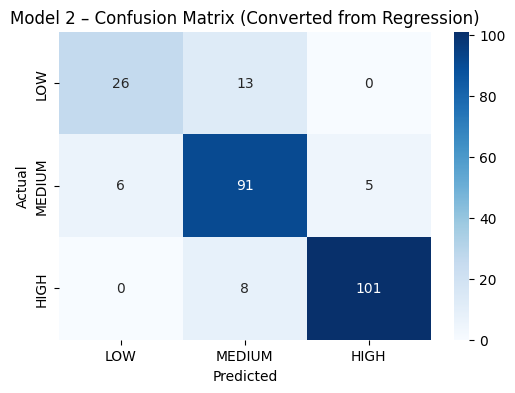

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["LOW", "MEDIUM", "HIGH"]

cm = confusion_matrix(y2_test_class, y2_pred_class, labels=labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Model 2 – Confusion Matrix (Converted from Regression)")
plt.show()


In [33]:
from sklearn.metrics import accuracy_score

cls_accuracy = accuracy_score(y2_test_class, y2_pred_class)
print("Classification Accuracy (Converted from Regression):", cls_accuracy)


Classification Accuracy (Converted from Regression): 0.872


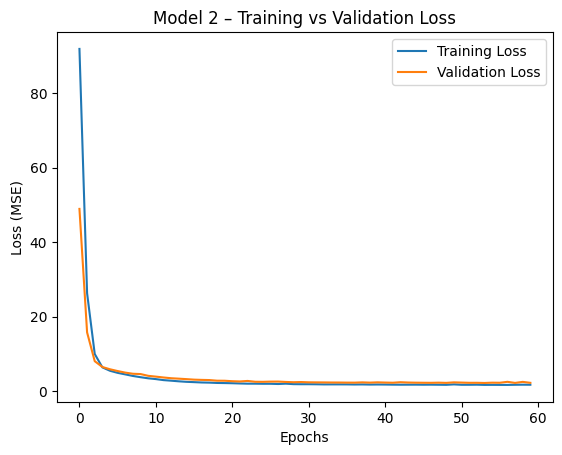

In [34]:
plt.plot(history_m2.history["loss"], label="Training Loss")
plt.plot(history_m2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model 2 – Training vs Validation Loss")
plt.legend()
plt.show()


In [35]:
from google.colab import files


In [38]:
import pickle

# Save first model
with open('model1_tf.pkl', 'wb') as f:
    pickle.dump(model1_tf, f)

# Save second model
with open('model2_tf.pkl', 'wb') as f:
    pickle.dump(model2_tf, f)

print("Models saved successfully!")


Models saved successfully!


In [39]:
from google.colab import files

files.download('model1_tf.pkl')  # download model 1
files.download('model2_tf.pkl')  # download model 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>